In [250]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM, TaskCDDMplus
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from rnn_coach.src.PerformanceAnalyzer import PerformanceAnalyzerCDDM
from scipy.sparse.linalg import lsqr
from copy import deepcopy
from sklearn.decomposition import PCA
import pandas as pd
import datetime
import pickle
from scipy.signal import savgol_filter
from scipy.optimize import minimize
from tqdm.auto import tqdm

In [251]:
task_name = "CDDM"
RNNs_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name)

In [252]:
RNNs = []
for folder in os.listdir(os.path.join('../', "data", "trained_RNNs", task_name)):
    if (folder == '.DS_Store'):
        pass
    else:
        if "relu" in folder:
            RNNs.append(folder)

In [253]:
len(RNNs)

327

In [254]:
names = []
scores = []
Ns = []
lmbdos = []
lmbdrs = []
lrs = []
activations = []
tags = []
maxiters = []
for folder in RNNs:
    day = float(datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%d'))
    month = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%m')
    if (month == '04') and (day >=23):
        files = os.listdir(os.path.join(RNNs_path, folder))
        config_file = None
        for file in files:
            if "config" in file:
                config_file = file
        config_data = json.load(open(os.path.join(RNNs_path, folder, config_file), "rb+"))
        score = np.round(float(config_file.split("_")[0]), 7)
        activation = config_data["activation"]
        N = config_data["N"]
        lmbdo = config_data["lambda_orth"]
        lmbdr = config_data["lambda_r"]
        lr=config_data["lr"]
        maxiter=config_data["max_iter"]
        extra_info = f"{task_name};{activation};N={N};lmbdo={lmbdo};lmbdr={lmbdr};lr={lr};maxiter={maxiter}"
        name = f"{score}_{extra_info}"
        tag = config_data["tag"]
        names.append(name)
        scores.append(score)
        Ns.append(N)
        lmbdos.append(lmbdo)
        lmbdrs.append(lmbdr)
        lrs.append(lr)
        tags.append(tag)
        activations.append(activation)
        maxiters.append(maxiter)

In [255]:
df = pd.DataFrame({"name" : names, "scores" : scores, "N" : Ns, "activation": activations, "lmbdo" : lmbdos, "lmbdr": lmbdrs, "lr" : lrs, "maxiter" : maxiters})

In [256]:
# additional filtering
df = df[df['lr'] == 0.002]
df = df[df['maxiter'] == 3000]

In [257]:
pd.set_option('display.max_rows', None)
df.sort_values("scores")

,name,scores,N,activation,lmbdo,lmbdr,lr,maxiter
57,0.0070617_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;...,0.007062,90,relu,0.3,0.05,0.002,3000
52,0.0070979_CDDM;relu;N=93;lmbdo=0.3;lmbdr=0.05;...,0.007098,93,relu,0.3,0.05,0.002,3000
2,0.007163_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;l...,0.007163,90,relu,0.3,0.05,0.002,3000
58,0.0071706_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.05;...,0.007171,95,relu,0.3,0.05,0.002,3000
1,0.0071953_CDDM;relu;N=89;lmbdo=0.3;lmbdr=0.05;...,0.007195,89,relu,0.3,0.05,0.002,3000
32,0.0071971_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.05;...,0.007197,95,relu,0.3,0.05,0.002,3000
21,0.0072101_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.05;...,0.007210,87,relu,0.3,0.05,0.002,3000
0,0.0072113_CDDM;relu;N=86;lmbdo=0.3;lmbdr=0.05;...,0.007211,86,relu,0.3,0.05,0.002,3000
39,0.0072446_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;...,0.007245,97,relu,0.3,0.05,0.002,3000
72,0.0072573_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.007257,99,relu,0.3,0.05,0.002,3000


In [258]:
top_RNNs = df.sort_values("scores")["name"].tolist()[:50]

In [259]:
top_RNNs

['0.0070617_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0070979_CDDM;relu;N=93;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.007163_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0071706_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0071953_CDDM;relu;N=89;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0071971_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072101_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072113_CDDM;relu;N=86;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072446_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072573_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072886_CDDM;relu;N=94;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.007289_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072974_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0073205_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3

# loading the RNNs and decoding information from them

In [260]:
num_rnn = 0
RNN_subfolder = top_RNNs[num_rnn]
RNN_score = float(top_RNNs[num_rnn].split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name, RNN_subfolder)
os.listdir(RNN_path)

['0.0070617_config.json',
 '0.0070617_LA_RHS.png',
 '0.0070617_params_CDDM.json',
 '0.0070617_psycho_data.json',
 '0.0070617_LA_3D.png',
 '0.0070617_psychometric_data.png',
 '0.0070617_random_trials.png',
 '0.0070617_train&valid_loss.png',
 '0.0070617_fp_data.json',
 '0.0070617_LA_data.pkl']

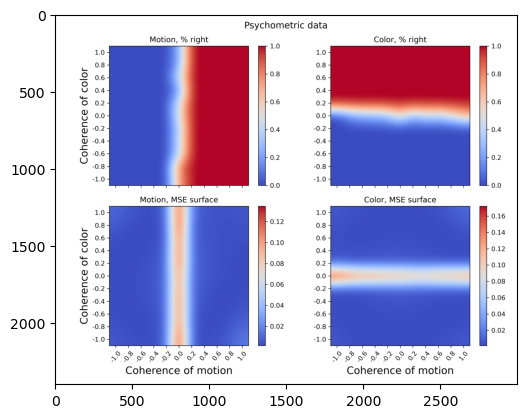

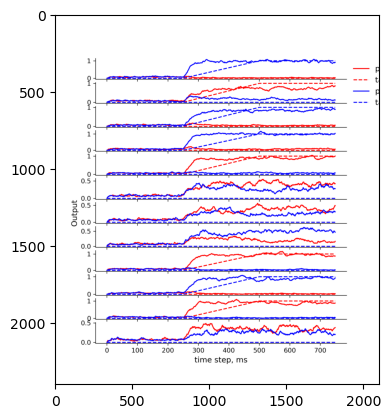

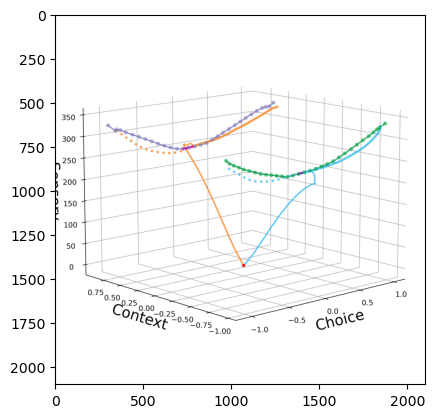

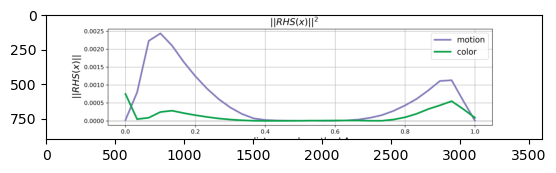

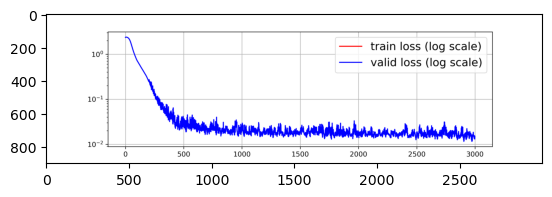

In [261]:
img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_psychometric_data.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_random_trials.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_LA_3D.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_LA_RHS.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_train&valid_loss.png"), 'rb+'))
plt.imshow(img)
plt.show()


In [262]:
RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_{task_name}.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))

In [263]:
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]
dt = RNN_config_file["dt"]
tau = RNN_config_file["tau"]

In [264]:
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)

    
if activation == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation == 'tanh':
    activation_RNN = torch.tanh
elif activation == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))
    
RNN = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN.set_params(RNN_params)

seed: 408877
Using cpu for RNN!


/Users/tolmach/Documents/GitHub/rnn_coach/jupyter/../../rnn_coach/src/RNN_torch.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tnsr = torch.normal(torch.tensor(mean).to(device), torch.tensor(std).to(device),


In [265]:
task_params_train = deepcopy(task_params)
# task_params_train["coherences"] = task_params["coherences"]
task_params_train["coherences"] = [-0.8, -0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.8]
task_train = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params_train)
input_batch_train, target_batch_train, conditions_batch_train = task_train.get_batch()
n_trials = len(conditions_batch_train)
n_steps = task_params_train["n_steps"]
RNN_train = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN_train.set_params(RNN_params)

# RNN_train.sigma_rec = RNN_train.sigma_inp = torch.tensor(0, device=RNN_train.device)
y_train, predicted_output_rnn_train = RNN_train(torch.from_numpy(input_batch_train.astype("float32")))
Y_train = np.hstack([y_train.detach().numpy()[:, :, i] for i in range(y_train.shape[-1])])
y_valid, predicted_output_rnn_valid = RNN_train(torch.from_numpy(input_batch_train.astype("float32")))
Y_valid = np.hstack([y_valid.detach().numpy()[:, :, i] for i in range(y_valid.shape[-1])])

RNN_train.sigma_rec = RNN_train.sigma_inp = torch.tensor(0, device=RNN_train.device)
y_noiseless, predicted_output_rnn_noiseless = RNN_train(torch.from_numpy(input_batch_train.astype("float32")))
Y_noiseless = np.hstack([y_noiseless.detach().numpy()[:, :, i] for i in range(y_noiseless.shape[-1])])

T_inp = np.hstack([input_batch_train[:, :, i] for i in range(input_batch_train.shape[-1])])
T_out = np.hstack([target_batch_train[:, :, i] for i in range(target_batch_train.shape[-1])])
T_out_masked = np.hstack([target_batch_train[:, mask, i] for i in range(target_batch_train.shape[-1])])
T_combined = np.vstack([T_inp, T_out])

traces_train = np.swapaxes(np.swapaxes(y_train.detach().numpy(), 0, -1), 1, -1)
traces_valid = np.swapaxes(np.swapaxes(y_valid.detach().numpy(), 0, -1), 1, -1)
traces_noiseless = np.swapaxes(np.swapaxes(y_noiseless.detach().numpy(), 0, -1), 1, -1)

Using cpu for RNN!


# TDR on {context, motion, color, choice}

In [266]:
Z = zscore(Y_train, axis = 1)
z = Z.reshape(-1, n_trials, n_steps)
z = np.swapaxes(z, 1, 2)

# PCA on Z
pca = PCA(n_components=20)
pca.fit(Z.T)
PCs = pca.components_
D = PCs.T @ PCs
Z_pca = D @ Z
z_pca = Z_pca.reshape(-1, n_trials, n_steps)
z_pca = np.swapaxes(z_pca, 1, 2)

Z_valid = zscore(Y_valid, axis = 1)
z_valid = Z_valid.reshape(-1, n_trials, n_steps)
z_valid = np.swapaxes(z_valid, 1, 2)

# PCA on Z
Z_pca_valid = D @ Z_valid
z_pca_valid = Z_pca_valid.reshape(-1, n_trials, n_steps)
z_pca_valid = np.swapaxes(z_pca_valid, 1, 2)

In [267]:
choice = np.array([conditions_batch_train[i]['correct_choice'] for i in range(len(conditions_batch_train))])
motion_coh = np.array([conditions_batch_train[i]['motion_coh'] for i in range(len(conditions_batch_train))])
color_coh = np.array([conditions_batch_train[i]['color_coh'] for i in range(len(conditions_batch_train))])
context = np.array([(1 if conditions_batch_train[i]['context']=='motion' else -1) for i in range(len(conditions_batch_train))])
F = np.hstack([context.reshape(-1, 1),
               motion_coh.reshape(-1, 1),
               color_coh.reshape(-1, 1),
               choice.reshape(-1, 1),
               np.ones((n_trials, 1))])


In [ ]:
regularization = 100
B_tdr = np.zeros((Z.shape[0], n_steps, F.shape[1]))

for i in range(Z.shape[0]):
    for t in range(n_steps):
        betas_i_t = lsqr(F, z_pca[i, t, :], damp=regularization)[0]
        B_tdr[i, t, :] = deepcopy(betas_i_t)
        
ind_cont = np.argmax(np.linalg.norm(B_tdr[:, :, 0], axis=0)[:250])
ind_motion = np.argmax(np.linalg.norm(B_tdr[:, :, 1], axis=0))
ind_color = np.argmax(np.linalg.norm(B_tdr[:, :, 2], axis=0))
ind_choice = np.argmax(np.linalg.norm(B_tdr[:, :, 3], axis=0))

context_direction = B_tdr[:, ind_cont, 0]/np.linalg.norm(B_tdr[:, ind_cont, 0])
motion_direction = B_tdr[:, ind_motion, 1]/np.linalg.norm(B_tdr[:, ind_motion, 1])
color_direction = B_tdr[:, ind_color, 2]/np.linalg.norm(B_tdr[:, ind_color, 2])
choice_direction = B_tdr[:, ind_choice, 3]/np.linalg.norm(B_tdr[:, ind_choice, 3])

B_tdr_max = np.hstack([choice_direction.reshape(-1, 1),
                   motion_direction.reshape(-1, 1),
                   color_direction.reshape(-1, 1),
                   context_direction.reshape(-1,1)])

In [270]:
print(ind_choice, ind_cont, ind_motion, ind_color)

708 189 710 578


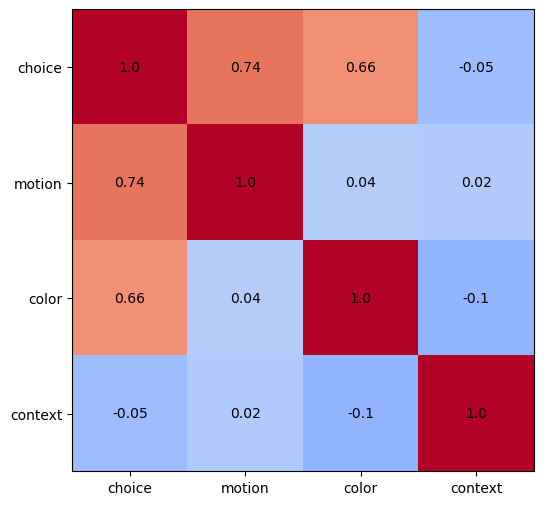

In [271]:
# correlations between the recovered directions
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
mat = B_tdr_max.T @ B_tdr_max
img2 = ax.imshow(mat, cmap='coolwarm', vmin = -0.5, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
ax.set_xticks(np.arange(4), ["choice", "motion", "color", "context"])
ax.set_yticks(np.arange(4), ["choice", "motion", "color", "context"])
plt.show()

choice axis is heavily correlated with the motion-color plane!

In [288]:
readout_direction = (W_out[0, :] - W_out[1, :])
readout_direction /= np.linalg.norm(readout_direction)
B_tdr_max = np.hstack([readout_direction.reshape(-1,1), 
                       motion_direction.reshape(-1, 1),
                       color_direction.reshape(-1, 1),
                       context_direction.reshape(-1, 1)])


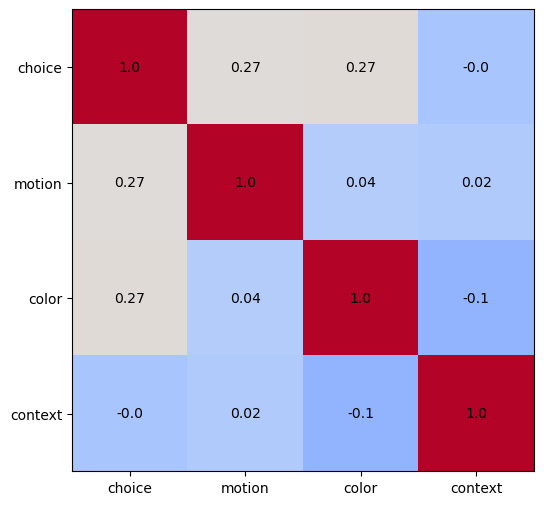

In [289]:
# correlations between the recovered directions
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
mat = B_tdr_max.T @ B_tdr_max
img2 = ax.imshow(mat, cmap='coolwarm', vmin = -0.5, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
ax.set_xticks(np.arange(4), ["choice", "motion", "color", "context"])
ax.set_yticks(np.arange(4), ["choice", "motion", "color", "context"])
plt.show()

In [297]:

permutation = [0,1, 2, 3]
labels = ["choice", "motion", "color", "context"]
labels_permuted = []
for i in permutation:
    labels_permuted.append(labels[i])
B_tdr_max = B_tdr_max[:, permutation]
B_tdr_orth, R = np.linalg.qr(B_tdr_max)

# U, S, V = np.linalg.svd(B_tdr)
# B_tdr_orth = U[:, :4] @ V

Decoded_vars_B = np.einsum("ij,kit->kjt", B_tdr_orth, traces_valid)

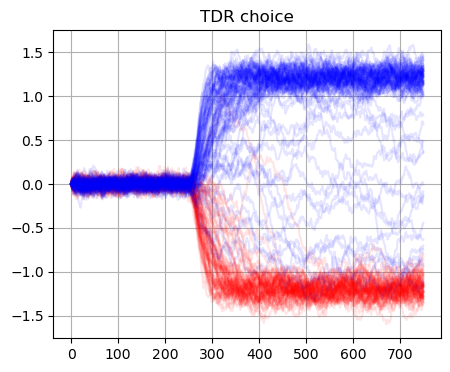

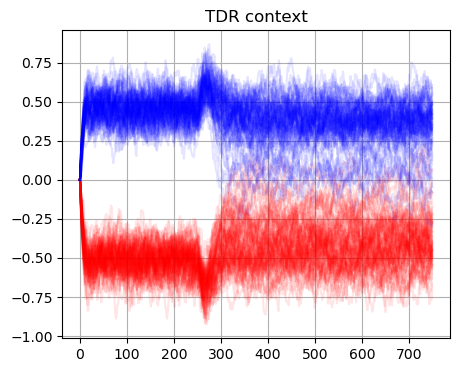

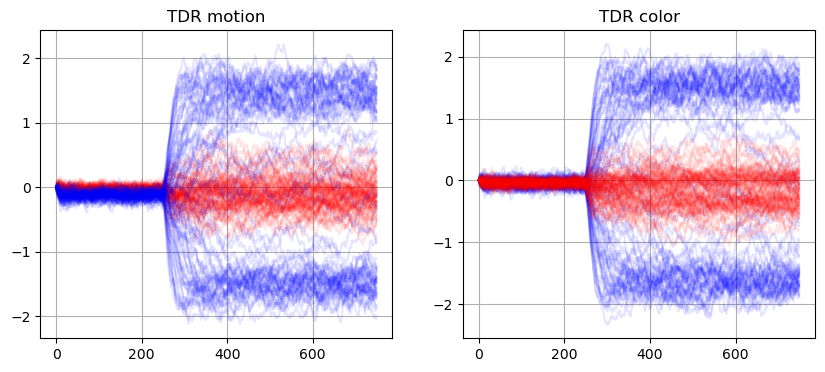

In [298]:
num_trials = Decoded_vars_B.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
choices = np.array([conditions_batch_train[i]["correct_choice"] for i in range(len(conditions_batch_train))])
ind_right_choice = np.where(choices == 1)[0]
ind_left_choice = np.where(choices == -1)[0]

ax.plot(Decoded_vars_B[ind_right_choice, labels_permuted.index("choice"), :].T, color='r', alpha=0.1, label = 'choice to right')
ax.plot(Decoded_vars_B[ind_left_choice, labels_permuted.index("choice"), :].T, color='b', alpha=0.1, label = 'choice to left')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('TDR choice')
ax.grid(True)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
choices = np.array([conditions_batch_train[i]["correct_choice"] for i in range(len(conditions_batch_train))])
ind_right_choice = np.where(choices == 1)[0]
ind_left_choice = np.where(choices == -1)[0]

ax.plot(Decoded_vars_B[:num_trials//2, labels_permuted.index("context"), :].T, color='r', alpha=0.1, label = 'context')
ax.plot(Decoded_vars_B[num_trials//2:, labels_permuted.index("context"), :].T, color='b', alpha=0.1, label = 'context')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('TDR context')
ax.grid(True)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(Decoded_vars_B[:num_trials//2, labels_permuted.index("motion"), :].T, color='r', alpha=0.1, label = 'relevant')
ax[0].plot(Decoded_vars_B[num_trials//2:, labels_permuted.index("motion"), :].T, color='b', alpha=0.1, label = 'irrelevant')
# ax[0].set_ylim([-15, 15])
ax[1].plot(Decoded_vars_B[:num_trials//2, labels_permuted.index("color"), :].T, color='b', alpha=0.1)
ax[1].plot(Decoded_vars_B[num_trials//2:, labels_permuted.index("color"), :].T, color='r', alpha=0.1)

# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax[0].title.set_text('TDR motion')
ax[1].title.set_text('TDR color')
ax[0].grid(True)
ax[1].grid(True)
plt.show()

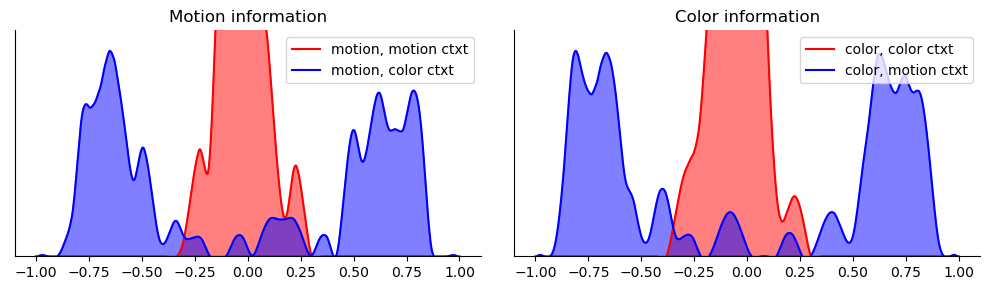

In [299]:
relevant_motion = np.mean(Decoded_vars_B[:num_trials//2, 1, 250:], axis = -1)
counts, bin_pos = np.histogram(relevant_motion, bins = 50, range= (-2.1,2.1))
interp1 = np.interp(np.linspace(-2.1, 2.1, 1001), bin_pos[1:], counts)
irrelevant_motion = np.mean(Decoded_vars_B[num_trials//2:, 1, 250:], axis = -1)
counts, bin_pos = np.histogram(irrelevant_motion, bins = 50, range= (-2.1,2.1))
interp2 = np.interp(np.linspace(-2.1, 2.1, 1001), bin_pos[1:], counts)
smoothed_rmotion = savgol_filter(interp1, 71, 3)
smoothed_irrmotion = savgol_filter(interp2, 71, 3)

relevant_color = np.mean(Decoded_vars_B[num_trials//2:, 2, 250:], axis = -1)
counts, bin_pos = np.histogram(relevant_color, bins = 50, range= (-2.1,2.1))
interp1 = np.interp(np.linspace(-2.1, 2.1, 1001), bin_pos[1:], counts)
irrelevant_color = np.mean(Decoded_vars_B[:num_trials//2, 2, 250:], axis = -1)
counts, bin_pos = np.histogram(irrelevant_color, bins = 50, range= (-2.1,2.1))
interp2 = np.interp(np.linspace(-2.1, 2.1, 1001), bin_pos[1:], counts)
smoothed_rcolor = savgol_filter(interp1, 71, 3)
smoothed_irrcolor = savgol_filter(interp2, 71, 3)

figure, ax = plt.subplots(1, 2, figsize = (10, 3))
x = np.linspace(-1, 1, len(smoothed_rmotion))
r = smoothed_rmotion
irr = smoothed_irrmotion
ax[0].plot(x, r, color = 'r', label='motion, motion ctxt')
ax[0].fill_between(x, r, where=r>=0, color='r', alpha=0.5, interpolate=True)
ax[0].plot(x, irr, color = 'b', label='motion, color ctxt')
ax[0].fill_between(x,irr, where=irr>=0, color='b', alpha=0.5, interpolate=True)
ax[0].set_ylim([0, 1.1 * np.max(irr)])
ax[0].set_title("Motion information")
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].legend(loc=1)
ax[0].set_yticks([])

x = np.linspace(-1, 1, len(smoothed_rcolor))
r = smoothed_rcolor
irr = smoothed_irrcolor
ax[1].plot(x, r, color = 'r', label='color, color ctxt')
ax[1].fill_between(x, r, where=r>=0, color='r', alpha=0.5, interpolate=True)
ax[1].plot(x, irr, color = 'b', label='color, motion ctxt')
ax[1].fill_between(x,irr, where=irr>=0, color='b', alpha=0.5, interpolate=True)
ax[1].set_ylim([0, 1.1 * np.max(irr)])
ax[1].set_title("Color information")
ax[1].spines[['right', 'top']].set_visible(False)
plt.tight_layout()
ax[1].legend(loc=1)
ax[1].set_yticks([])
plt.show()

ValueError: could not broadcast input array from shape (450,) into shape (90,)

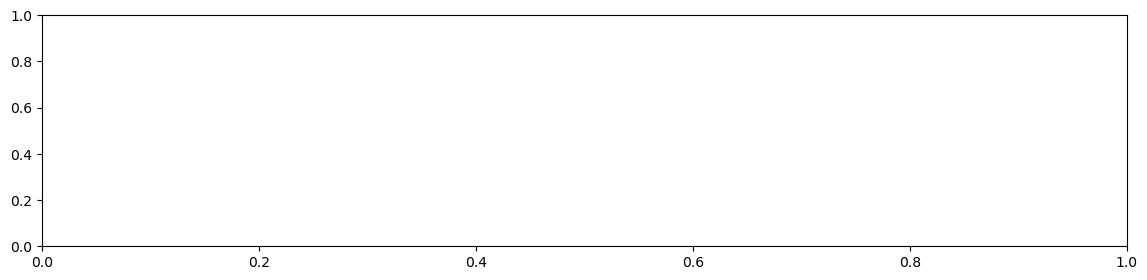

In [40]:
plt.figure(figsize=(14, 3))
plt.stem(B_tdr[:, 1], markerfmt='bo')
plt.xticks(np.arange(B_tdr.shape[0]), rotation = 50, fontsize = 7)
plt.grid(True)
plt.show()

In [ ]:
def plot_neurons_stats(traces, num_nrn, conditions, cohrences_list):
    neural_traces = traces[:, num_nrn, :]
    contexts = np.array([1 if d["context"]=='motion' else 0 for d in conditions])
    motion_coherences = np.array([d["motion_coh"] for d in conditions])
    color_coherences = np.array([d["color_coh"] for d in conditions])
    inds_motion_ctxt = np.where(contexts==1)[0]
    inds_color_ctxt = np.where(contexts==0)[0]

    data_dict = {}
    for ctx in ["motion", "color"]:
        val = 1 if ctx == 'motion' else 0
        inds_context = np.where(contexts==val)[0]
        for part in ["start", "end"]:
            if part == 'start':
                mfr = np.mean(neural_traces[inds_context, :n_steps//3], axis = 1)
            elif part == 'end':
                mfr = np.mean(neural_traces[inds_context, n_steps//3:], axis = 1)

            M = np.zeros((len(cohrences_list), len(cohrences_list)))
            for i in range(len(mfr)):
                coh_motion = np.take(motion_coherences, inds_context)[i]
                coh_color = np.take(color_coherences, inds_context)[i]
                i1 = np.where(cohrences_list == coh_motion)[0][0]
                i2 = np.where(cohrences_list == coh_color)[0][0]
                M[i1, i2] = mfr[i]
            data_dict[(ctx, part)] = deepcopy(M)
            
    figure, ax = plt.subplots(2, 2, figsize = (7, 7))
    plt.suptitle("Neural responses")
    imgs = []
    for i, ctx in enumerate(["motion", "color"]):
        for j, part in enumerate(["start", "end"]):
            imgs.append(ax[j, i].imshow(data_dict[(ctx, part)], cmap = 'coolwarm', vmin = 0, interpolation='bicubic'))
            ax[j, i].set_xticks(np.arange(len(cohrences_list)), cohrences_list, rotation = 50, fontsize = 6)
            ax[j, i].set_yticks(np.arange(len(cohrences_list)), cohrences_list, rotation = 50, fontsize = 6)
            ax[j, i].set_xlabel("Color")
            ax[j, i].set_ylabel("Motion")

    cnt = 0
    for i, ctx in enumerate(["motion", "color"]):
        for j, part in enumerate(["start", "end"]):        
            figure.colorbar(imgs[cnt], ax=ax[j, i], cax=ax[j, i].inset_axes([1.05, 0, 0.05, 1]))
            cnt+=1

    plt.subplots_adjust(hspace = 0.4, wspace = 0.65)
    plt.show()

In [ ]:
num_nrn = 64
plot_neurons_stats(traces=traces_valid, num_nrn=num_nrn, conditions=conditions_batch_train, cohrences_list=task_params_train["coherences"])

In [ ]:
Decoded_vars_B = np.einsum("ij,kit->kjt", B_tdr_orth, traces_noiseless)
motion_B = Decoded_vars_B[:, labels_permuted.index("motion"), :] 
color_B = Decoded_vars_B[:, labels_permuted.index("color"), :] 
choice_B = Decoded_vars_B[:, labels_permuted.index("choice"), :] 

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
for i in range(motion_B.shape[0]):
    if i < choice_B.shape[0]//2:
        cs = (np.abs(conditions_batch_train[i]["motion_coh"]), 0, np.abs(conditions_batch_train[i]["color_coh"]))
        alpha = 0.1 + 0.9*np.abs(conditions_batch_train[i]["motion_coh"]**2)
        linestyle = '-'
    else:
        cs = (np.abs(conditions_batch_train[i]["motion_coh"]), 0, np.abs(conditions_batch_train[i]["color_coh"]))
        alpha = 0.1 + 0.9*np.abs(conditions_batch_train[i]["color_coh"]**2)
        linestyle = '--'
    ax[0].plot(choice_B[i, :], motion_B[i, :], color=cs, alpha = alpha, linestyle=linestyle)
ax[0].set_ylabel("motion", fontsize = 14)


for i in range(motion_B.shape[0]):
    if i < choice_B.shape[0]//2:
        cs = (np.abs(conditions_batch_train[i]["motion_coh"]), 0, np.abs(conditions_batch_train[i]["color_coh"]))
        alpha = 0.1 + 0.9*np.abs(conditions_batch_train[i]["color_coh"]**2)
        linestyle = '-'
    else:
        cs = (np.abs(conditions_batch_train[i]["motion_coh"]), 0, np.abs(conditions_batch_train[i]["color_coh"]))
        alpha = 0.1 + 0.9*np.abs(conditions_batch_train[i]["color_coh"]**2)
        linestyle = '--'
    ax[1].plot(choice_B[i, :], color_B[i, :], color=cs, alpha = alpha, linestyle=linestyle)
ax[1].set_ylabel("color", fontsize = 14)
for j in range(2):
    ax[j].grid(True)
    ax[j].set_xlabel("choice", fontsize = 14)
plt.show()

In [ ]:
# # %matplotlib notebook
# Decoded_vars_B_tdr_readout_noiseless = np.einsum("ij,kit->kjt", B_tdr_orth_readout, traces_noiseless)
# choice_B = Decoded_vars_B_tdr_readout_noiseless[:, 0, :] 
# motion_B = Decoded_vars_B_tdr_readout_noiseless[:, 1, :] 
# color_B = Decoded_vars_B_tdr_readout_noiseless[:, 2, :] 

# # Decoded_vars_B_tdr_choice_noiseless = np.einsum("ij,kit->kjt", B_tdr_orth_choice, traces_noiseless)
# # choice_B = Decoded_vars_B_tdr_choice_noiseless[:, 0, :] 
# # motion_B = Decoded_vars_B_tdr_choice_noiseless[:, 1, :] 
# # color_B = Decoded_vars_B_tdr_choice_noiseless[:, 2, :] 


# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# for i in range(choice_B.shape[0]):
#     xs = choice_B[i, :] 
#     ys = motion_B[i, :] 
#     zs = color_B[i, :] 
#     if i < choice_B.shape[0]//2:
#         cs = (np.abs(conditions_batch_train[i]["motion_coh"]), 0, np.abs(conditions_batch_train[i]["color_coh"]))
#         alpha = np.abs(conditions_batch_train[i]["motion_coh"]**2)
#     else:
#         cs = (np.abs(conditions_batch_train[i]["motion_coh"]), 0, np.abs(conditions_batch_train[i]["color_coh"]))
#         alpha = 0.1 + 0.9*np.abs(conditions_batch_train[i]["color_coh"]**2)
# #     ax.scatter(xs, ys, zs, color=colors[lbl], edgecolor='k')
#     ax.plot(xs, ys, zs, color=cs, alpha = alpha)
#     ax.set_xlabel("Choice", fontsize = 16)
#     ax.set_ylabel("Motion", fontsize = 16)
#     ax.set_zlabel("Color", fontsize = 16)
# ax.view_init(elev=4, azim=2, roll=0)
# ax.view_init(elev=4, azim=2, roll=0)
# plt.tight_layout()
# plt.show()

### variance explained

In [ ]:
mean_frs_first = np.mean(traces_valid[:, :, :250], axis = -1)
mean_frs_last = np.mean(traces_valid[:, :, 500:], axis = -1)

total_var_first = np.sum((mean_frs_first - np.mean(mean_frs_first, axis = 0))**2)
total_var_last = np.sum((mean_frs_last - np.mean(mean_frs_last, axis = 0))**2)

axis_vars = []
for i in range(4):
    v = (mean_frs_first @ B_tdr_orth[:, i])
    axis_var = np.sum((v - np.mean(v))**2)
    axis_vars.append(axis_var)
print(np.array(axis_vars) / total_var_first)

axis_vars = []
for i in range(4):
    v = (mean_frs_last @ B_tdr_orth[:, i])
    axis_var = np.sum((v - np.mean(v))**2)
    axis_vars.append(axis_var)
print(np.array(axis_vars) / total_var_last)

# comparing with Q

In [ ]:
LA_data = pickle.load(open(os.path.join(RNN_path, f"{RNN_score}_LA_data.pkl"), "rb+"))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (16, 7))
ax[0].imshow(LA_data["motion"]["l"][5:-5, :], cmap='coolwarm', vmin = -1, vmax = 1)
ax[0].title.set_text('motion ctx, selection vector')
ax[1].imshow(LA_data["color"]["l"][5:-5, :], cmap='coolwarm', vmin = -1, vmax = 1)
ax[1].title.set_text('color ctx, selection vector')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
avg_sv_motion = np.mean(LA_data["motion"]["l"][5:-5, :], axis = 0)
avg_sv_color = np.mean(LA_data["color"]["l"][5:-5, :], axis = 0)
avg_sv_motion /= np.linalg.norm(avg_sv_motion)
avg_sv_color /= np.linalg.norm(avg_sv_color)
Sv = np.hstack([avg_sv_motion.reshape(-1, 1), avg_sv_color.reshape(-1, 1)])

In [ ]:
LC_folder = RNN_subfolder
RNN_score = float(RNN_subfolder.split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", "CDDMplus", RNN_subfolder)
LC_folder_path = os.path.join('../', '../', "latent_circuit_inference", "data", "inferred_LCs", LC_folder)
subfolders = os.listdir(LC_folder_path)
varianses = []
variances_pr = []
names = []
for i, subfolder in enumerate(subfolders):
    if "8nodes" in subfolder or "8-nodes" in subfolder:
        score = float(subfolder.split("_")[0])
        score_pr = float(subfolder.split("_")[1])
        varianses.append(score)
        variances_pr.append(score_pr)
        names.append(subfolder)
lc_df = pd.DataFrame({"name" : names, "variance" : varianses, "variance_pr" : variances_pr})
top_LCs = lc_df.sort_values("variance", ascending=False)["name"].tolist()

In [ ]:
LC_subfolder = top_LCs[0]
print(LC_subfolder)
score = float(LC_subfolder.split("_")[0])
score_pr = float(LC_subfolder.split("_")[1])
LC_path = os.path.join(LC_folder_path, LC_subfolder)
LC_data = json.load(open(os.path.join(LC_path, f"{score}_{score_pr}_LC_params.json"), "rb+"))
U = np.array(LC_data["U"])
q = np.array(LC_data["q"])
Q = U.T @ q
w_out = np.array(LC_data["W_out"])
w_rec = np.array(LC_data["W_rec"])
w_inp = np.array(LC_data["W_inp"])
N = LC_data["N"]
dt = LC_data["dt"]
tau = LC_data["tau"]

print(f"Total variance explained: {np.round(score,4)}")
print(f"Projected variance explained: {np.round(score_pr,4)}")
day = float(datetime.datetime.fromtimestamp(os.path.getmtime(LC_path)).strftime('%d'))
print(f"Day of the file {day}")

In [ ]:
readout_direction = (W_out[0, :] - W_out[1, :])
readout_direction /= np.linalg.norm(readout_direction)
B_tdr_max = np.hstack([choice_direction.reshape(-1,1), 
                       motion_direction.reshape(-1, 1),
                       color_direction.reshape(-1, 1),
                       context_direction.reshape(-1, 1)])

permutation = [0, 1, 2, 3]
labels = ["choice", "motion", "color", "context"]
labels_permuted = []
for i in permutation:
    labels_permuted.append(labels[i])
B_tdr_max = B_tdr_max[:, permutation]
B_tdr_orth, R = np.linalg.qr(B_tdr_max)
# U, S, V = np.linalg.svd(B_tdr_max)
# B_tdr_orth = U[:, :4] @ V
Decoded_vars_B = np.einsum("ij,kit->kjt", B_tdr_orth, traces_valid)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

mat = (B_tdr_orth.T @ Sv).T
ax.imshow(mat, cmap='coolwarm', vmin = -0.9, vmax = 0.9)
ax.set_xticks(np.arange(4), labels_permuted)
ax.set_yticks(np.arange(2), ["motion S.V.", "color S.V."])
for (i, j), z in np.ndenumerate(mat):
    ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
plt.tight_layout()
plt.subplots_adjust(wspace = 0.0)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

mat = (Q.T @ B_tdr_orth)
ax.imshow(mat, cmap='coolwarm', vmin = -0.9, vmax = 0.9)
ax.set_xticks(np.arange(4), ["choice", "motion", "color", "context"])
ax.set_yticks(np.arange(8), ["ctx m", "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"])
for (i, j), z in np.ndenumerate(mat):
    ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
plt.tight_layout()
plt.subplots_adjust(wspace = 0.0)
plt.show()

In [ ]:
W_out = np.array(RNN_data["W_out"])

In [ ]:
mat = (B_tdr_orth.T @ W_out.T).T
fig, ax = plt.subplots(3, 1, figsize=(6,6))

mat = (Q.T @ W_out.T).T
ax[0].imshow(mat, cmap='coolwarm', vmin = -0.7, vmax = 0.7)
ax[0].set_xticks(np.arange(8), ["ctx m", "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"])
ax[0].set_yticks(np.arange(2), ["W OutR", "W OutL"])
for (i, j), z in np.ndenumerate(mat):
    ax[0].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')

ax[1].imshow(mat, cmap='coolwarm', vmin = -0.7, vmax = 0.7)
ax[1].set_xticks(np.arange(8), ["ctx m", "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"])
ax[1].set_yticks(np.arange(2), ["W OutR", "W OutL"])
for (i, j), z in np.ndenumerate(mat):
    ax[1].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
mat = (B_tdr_orth.T @ W_out.T).T
ax[2].imshow(mat, cmap='coolwarm', vmin = -0.7, vmax = 0.7)
ax[2].set_xticks(np.arange(8), ["ctx m", "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"])
ax[2].set_yticks(np.arange(2), ["W OutR", "W OutL"])
for (i, j), z in np.ndenumerate(mat):
    ax[2].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
plt.tight_layout()
plt.subplots_adjust(wspace = 0.0)
plt.show()

# TDR on circuit

In [150]:
labels = ["ctx m", "ctx c", "mR inp", "mL inp", "cR inp", "cL inp", "mR", "mL", "cR", "cL", "OutR", "OutL"]
W_inp = np.zeros((12, 6))
W_rec = np.zeros((12, 12))
W_out = np.zeros((2, 12))

W_inp[labels.index("ctx m"), 0] = 1.0
W_inp[labels.index("ctx c"), 1] = 1.0
W_inp[labels.index("mR inp"), 2] = 1.0
W_inp[labels.index("mL inp"), 3] = 1.0
W_inp[labels.index("cR inp"), 4] = 1.0
W_inp[labels.index("cL inp"), 5] = 1.0

W_rec[labels.index("mR"), labels.index("mR inp")] = 1.0
W_rec[labels.index("mL"), labels.index("mL inp")] = 1.0
W_rec[labels.index("cR"), labels.index("cR inp")] = 1.0
W_rec[labels.index("cL"), labels.index("cL inp")] = 1.0

W_rec[labels.index("mR"), labels.index("ctx c")] = -1.2
W_rec[labels.index("mL"), labels.index("ctx c")] = -1.2
W_rec[labels.index("cR"), labels.index("ctx m")] = -1.2
W_rec[labels.index("cL"), labels.index("ctx m")] = -1.2

W_rec[labels.index("OutR"), labels.index("mR")] = 1.1
W_rec[labels.index("OutR"), labels.index("cR")] = 1.1
W_rec[labels.index("OutL"), labels.index("mL")] = 1.1
W_rec[labels.index("OutL"), labels.index("cL")] = 1.1

# W_rec[labels.index("mR"), labels.index("mL")] = -0.4
# W_rec[labels.index("mL"), labels.index("mR")] = -0.4
# W_rec[labels.index("cR"), labels.index("cL")] = -0.4
# W_rec[labels.index("cL"), labels.index("cR")] = -0.4
W_rec[labels.index("mR"), labels.index("cL")] = -0.2
W_rec[labels.index("mR"), labels.index("cR")] = -0.2
W_rec[labels.index("mL"), labels.index("cL")] = -0.2
W_rec[labels.index("mL"), labels.index("cR")] = -0.2
W_rec[labels.index("cR"), labels.index("mL")] = -0.2
W_rec[labels.index("cR"), labels.index("mR")] = -0.2
W_rec[labels.index("cL"), labels.index("mL")] = -0.2
W_rec[labels.index("cL"), labels.index("mR")] = -0.2
W_rec[labels.index("OutL"), labels.index("OutR")] = -0.5
W_rec[labels.index("OutR"), labels.index("OutL")] = -0.5

W_out[0, labels.index("OutR")] = 1.0
W_out[1, labels.index("OutL")] = 1.0

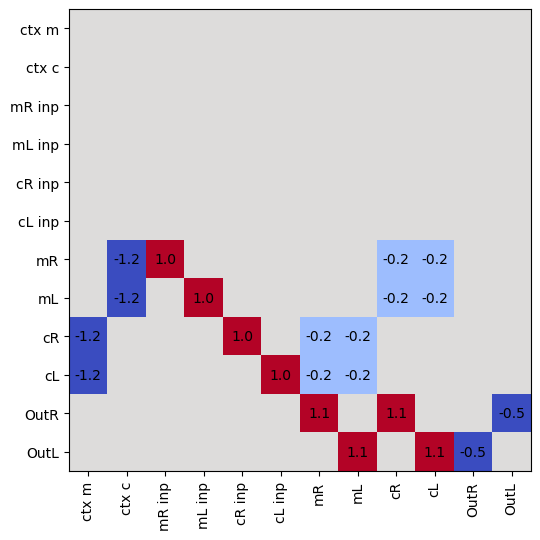

In [151]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
mat = W_rec
img2 = ax.imshow(mat, cmap='coolwarm', vmin = -0.5, vmax = 0.5)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z)< 0.03:
        pass
    else:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
ax.set_xticks(np.arange(12), labels, rotation=90)
ax.set_yticks(np.arange(12), labels)
plt.show()

In [152]:
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)

    
if activation == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation == 'tanh':
    activation_RNN = torch.tanh
elif activation == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))
    
RNN = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN.set_params(RNN_params)

seed: 225679
Using cpu for RNN!


/Users/tolmach/Documents/GitHub/rnn_coach/jupyter/../../rnn_coach/src/RNN_torch.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tnsr = torch.normal(torch.tensor(mean).to(device), torch.tensor(std).to(device),


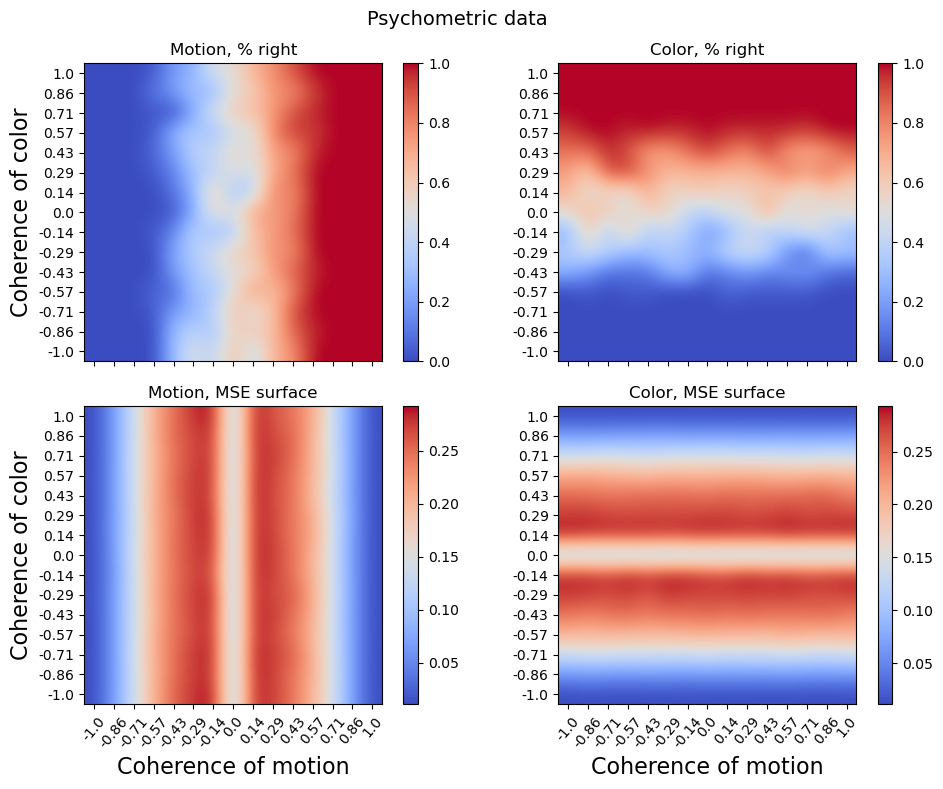

In [153]:
RNNnp = RNN_numpy(N=W_rec.shape[0], dt=dt, tau=tau, W_inp=W_inp, W_rec = W_rec, W_out=W_out)
pa = PerformanceAnalyzerCDDM(RNNnp)
pa.calc_psychometric_data(task, mask, num_levels=15, num_repeats=31)
pa.plot_psychometric_data()
plt.show()

In [154]:
# RNN_train.sigma_rec = RNN_train.sigma_inp = torch.tensor(0, device=RNN_train.device)
y_train, predicted_output_rnn_train = RNN(torch.from_numpy(input_batch_train.astype("float32")))
Y_train = np.hstack([y_train.detach().numpy()[:, :, i] for i in range(y_train.shape[-1])])
y_valid, predicted_output_rnn_valid = RNN(torch.from_numpy(input_batch_train.astype("float32")))
Y_valid = np.hstack([y_valid.detach().numpy()[:, :, i] for i in range(y_valid.shape[-1])])

RNN.sigma_rec = RNN.sigma_inp = torch.tensor(0, device=RNN.device)
y_noiseless, predicted_output_rnn_noiseless = RNN(torch.from_numpy(input_batch_train.astype("float32")))
Y_noiseless = np.hstack([y_noiseless.detach().numpy()[:, :, i] for i in range(y_noiseless.shape[-1])])

T_inp = np.hstack([input_batch_train[:, :, i] for i in range(input_batch_train.shape[-1])])
T_out = np.hstack([target_batch_train[:, :, i] for i in range(target_batch_train.shape[-1])])
T_out_masked = np.hstack([target_batch_train[:, mask, i] for i in range(target_batch_train.shape[-1])])
T_combined = np.vstack([T_inp, T_out])

traces_train = np.swapaxes(np.swapaxes(y_train.detach().numpy(), 0, -1), 1, -1)
traces_valid = np.swapaxes(np.swapaxes(y_valid.detach().numpy(), 0, -1), 1, -1)
traces_noiseless = np.swapaxes(np.swapaxes(y_noiseless.detach().numpy(), 0, -1), 1, -1)

In [155]:
Z = zscore(Y_train, axis = 1)
z = Z.reshape(-1, n_trials, n_steps)
z = np.swapaxes(z, 1, 2)

# PCA on Z
pca = PCA(n_components=12)
pca.fit(Z.T)
PCs = pca.components_
D = PCs.T @ PCs
Z_pca = D @ Z
z_pca = Z_pca.reshape(-1, n_trials, n_steps)
z_pca = np.swapaxes(z_pca, 1, 2)

Z_valid = zscore(Y_valid, axis = 1)
z_valid = Z_valid.reshape(-1, n_trials, n_steps)
z_valid = np.swapaxes(z_valid, 1, 2)

# PCA on Z
Z_pca_valid = D @ Z_valid
z_pca_valid = Z_pca_valid.reshape(-1, n_trials, n_steps)
z_pca_valid = np.swapaxes(z_pca_valid, 1, 2)

In [156]:
choice = np.array([conditions_batch_train[i]['correct_choice'] for i in range(len(conditions_batch_train))])
motion_coh = np.array([conditions_batch_train[i]['motion_coh'] for i in range(len(conditions_batch_train))])
color_coh = np.array([conditions_batch_train[i]['color_coh'] for i in range(len(conditions_batch_train))])
context = np.array([(1 if conditions_batch_train[i]['context']=='motion' else -1) for i in range(len(conditions_batch_train))])
F = np.hstack([context.reshape(-1, 1),
               motion_coh.reshape(-1, 1),
               color_coh.reshape(-1, 1),
               choice.reshape(-1, 1),
               np.ones((n_trials, 1))])


In [247]:
regularization = 0.33
B_tdr = np.zeros((Z.shape[0], n_steps, F.shape[1]))
from sklearn.linear_model import Lasso

for i in tqdm(range(Z.shape[0])):
    for t in range(n_steps):
#         betas_i_t = lsqr(F, z_pca[i, t, :], damp=regularization)[0]
        reg = Lasso(alpha = regularization).fit(F, z_pca[i, t, :])
        B_tdr[i, t, :] = deepcopy(reg.coef_)
        
ind_cont = np.argmax(np.linalg.norm(B_tdr[:, :, 0], axis=0, ord=1)[:250])
ind_motion = np.argmax(np.linalg.norm(B_tdr[:, :, 1], axis=0, ord=1))
ind_color = np.argmax(np.linalg.norm(B_tdr[:, :, 2], axis=0, ord=1))
ind_choice = np.argmax(np.linalg.norm(B_tdr[:, :, 3], axis=0, ord=1))

context_direction = B_tdr[:, ind_cont, 0]/np.linalg.norm(B_tdr[:, ind_cont, 0])
motion_direction = B_tdr[:, ind_motion, 1]/np.linalg.norm(B_tdr[:, ind_motion, 1])
color_direction = B_tdr[:, ind_color, 2]/np.linalg.norm(B_tdr[:, ind_color, 2])
choice_direction = B_tdr[:, ind_choice, 3]/np.linalg.norm(B_tdr[:, ind_choice, 3])

B_tdr_max = np.hstack([choice_direction.reshape(-1, 1),
                   motion_direction.reshape(-1, 1),
                   color_direction.reshape(-1, 1),
                   context_direction.reshape(-1,1)])

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/tolmach/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/tolmach/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/tolmach/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

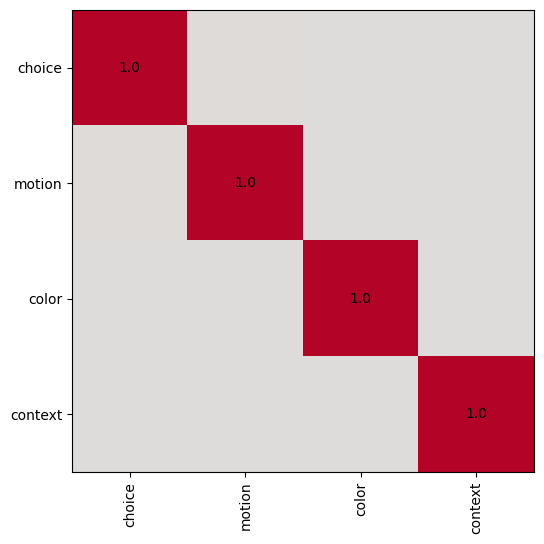

In [248]:
# correlations between the recovered directions
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
mat = B_tdr_max.T @ B_tdr_max
img2 = ax.imshow(mat, cmap='coolwarm', vmin = -0.5, vmax = 0.5)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z)< 0.03:
        pass
    else:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
ax.set_yticks(np.arange(4), ["choice", "motion", "color", "context"])
ax.set_xticks(np.arange(4), ["choice", "motion", "color", "context"], rotation=90)
plt.show()

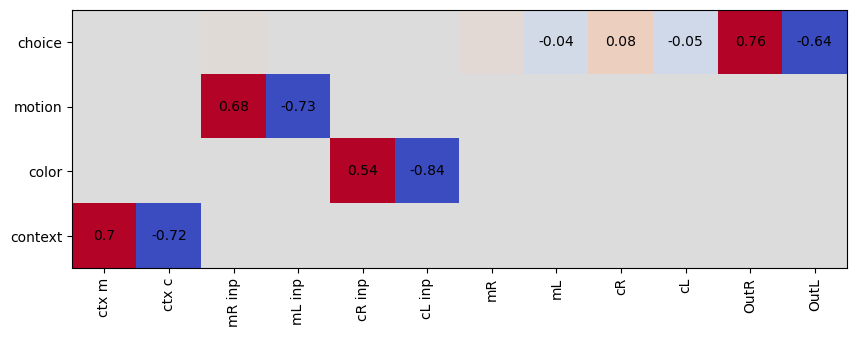

In [249]:
# correlations between the recovered directions
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
mat = B_tdr_max.T
img2 = ax.imshow(mat, cmap='coolwarm', vmin = -0.5, vmax = 0.5)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) < 0.03:
        pass
    else:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
ax.set_yticks(np.arange(4), ["choice", "motion", "color", "context"])
ax.set_xticks(np.arange(12), labels, rotation=90)
plt.show()

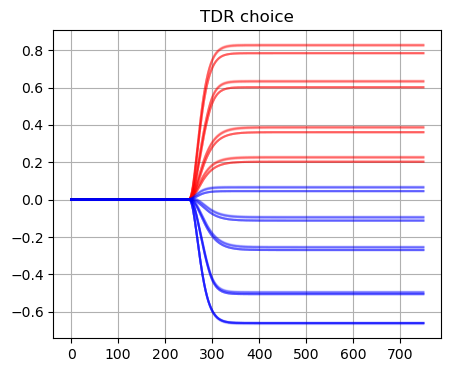

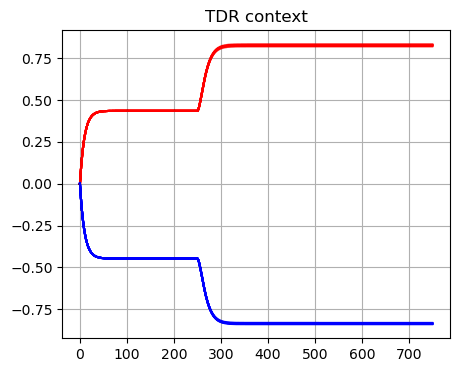

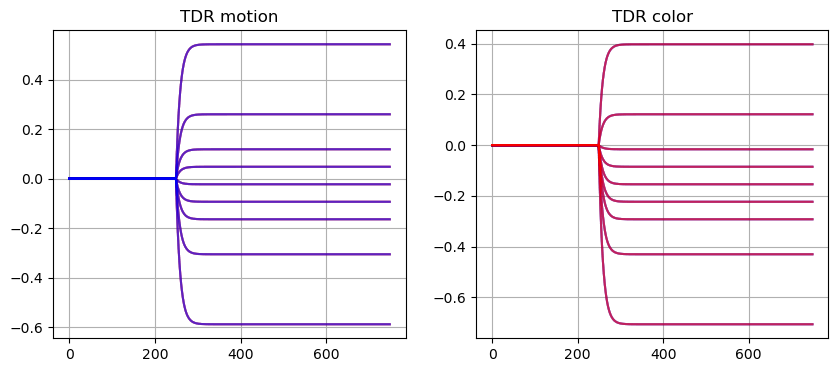

In [246]:
Decoded_vars_B = np.einsum("ij,kit->kjt", B_tdr_max, traces_noiseless)

num_trials = Decoded_vars_B.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
choices = np.array([conditions_batch_train[i]["correct_choice"] for i in range(len(conditions_batch_train))])
ind_right_choice = np.where(choices == 1)[0]
ind_left_choice = np.where(choices == -1)[0]

ax.plot(Decoded_vars_B[ind_right_choice, labels_permuted.index("choice"), :].T, color='r', alpha=0.1, label = 'choice to right')
ax.plot(Decoded_vars_B[ind_left_choice, labels_permuted.index("choice"), :].T, color='b', alpha=0.1, label = 'choice to left')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('TDR choice')
ax.grid(True)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
choices = np.array([conditions_batch_train[i]["correct_choice"] for i in range(len(conditions_batch_train))])
ind_right_choice = np.where(choices == 1)[0]
ind_left_choice = np.where(choices == -1)[0]

ax.plot(Decoded_vars_B[:num_trials//2, labels_permuted.index("context"), :].T, color='r', alpha=0.1, label = 'context')
ax.plot(Decoded_vars_B[num_trials//2:, labels_permuted.index("context"), :].T, color='b', alpha=0.1, label = 'context')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('TDR context')
ax.grid(True)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(Decoded_vars_B[:num_trials//2, labels_permuted.index("motion"), :].T, color='r', alpha=0.1, label = 'relevant')
ax[0].plot(Decoded_vars_B[num_trials//2:, labels_permuted.index("motion"), :].T, color='b', alpha=0.1, label = 'irrelevant')
# ax[0].set_ylim([-15, 15])
ax[1].plot(Decoded_vars_B[:num_trials//2, labels_permuted.index("color"), :].T, color='b', alpha=0.1)
ax[1].plot(Decoded_vars_B[num_trials//2:, labels_permuted.index("color"), :].T, color='r', alpha=0.1)

# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax[0].title.set_text('TDR motion')
ax[1].title.set_text('TDR color')
ax[0].grid(True)
ax[1].grid(True)
plt.show()